# Import required libraries

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.cm as cm
from matplotlib import pyplot as plt 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense

# packages for learning from crowds
from crowd_layer.crowd_layers import CrowdsClassification, MaskedMultiCrossEntropy
from crowd_layer.crowd_aggregators import CrowdsCategoricalAggregator

# prevent tensorflow from allocating the entire GPU memory at once
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

Using TensorFlow backend.


# Configuration parameters

In [2]:
NUM_RUNS = 30
DATA_PATH = "/home/fmpr/datasets/deep-crowds-datasets/LabelMe/prepared/"
N_CLASSES = 8
BATCH_SIZE = 64
N_EPOCHS = 50

# Load data

In [3]:
def load_data(filename):
    f = open(filename)
    data = np.load(f)
    f.close()
    return data

In [4]:
print ("\nLoading train data...")

# images processed by VGG16
data_train_vgg16 = load_data(DATA_PATH+"data_train_vgg16.npy")
print (data_train_vgg16.shape)

# ground truth labels
labels_train = load_data(DATA_PATH+"labels_train.npy")
print (labels_train.shape)

# labels obtained from majority voting
labels_train_mv = load_data(DATA_PATH+"labels_train_mv.npy")
print (labels_train_mv.shape)

# labels obtained by using the approach by Dawid and Skene
labels_train_ds = load_data(DATA_PATH+"labels_train_DS.npy")
print (labels_train_ds.shape)

# data from Amazon Mechanical Turk
print ("\nLoading AMT data...")
answers = load_data(DATA_PATH+"answers.npy")
print (answers.shape)
N_ANNOT = answers.shape[1]
print ("\nN_CLASSES:", N_CLASSES)
print ("N_ANNOT:", N_ANNOT)

# load test data
print ("\nLoading test data...")

# images processed by VGG16
data_test_vgg16 = load_data(DATA_PATH+"data_test_vgg16.npy")
print (data_test_vgg16.shape)

# test labels
labels_test = load_data(DATA_PATH+"labels_test.npy")
print (labels_test.shape)


Loading train data...
(10000, 150, 150, 3)
(10000, 4, 4, 512)
(10000,)
(10000,)
(10000,)

Loading AMT data...
(10000, 59)

N_CLASSES: 8
N_ANNOT: 59

Loading test data...
(1188, 150, 150, 3)
(1188, 4, 4, 512)
(1188,)


# Convert data to one-hot encoding

In [5]:
def one_hot(target, n_classes):
    targets = np.array([target]).reshape(-1)
    one_hot_targets = np.eye(n_classes)[targets]
    return one_hot_targets

In [6]:
print ("\nConverting to one-hot encoding...")
labels_train_bin = one_hot(labels_train, N_CLASSES)
print (labels_train_bin.shape)
labels_train_mv_bin = one_hot(labels_train_mv, N_CLASSES)
print (labels_train_mv_bin.shape)
labels_train_ds_bin = one_hot(labels_train_ds, N_CLASSES)
print (labels_train_ds_bin.shape)
labels_test_bin = one_hot(labels_test, N_CLASSES)
print (labels_test_bin.shape)

answers_bin_missings = []
for i in range(len(answers)):
    row = []
    for r in range(N_ANNOT):
        if answers[i,r] == -1:
            row.append(-1 * np.ones(N_CLASSES))
        else:
            row.append(one_hot(answers[i,r], N_CLASSES)[0,:])
    answers_bin_missings.append(row)
answers_bin_missings = np.array(answers_bin_missings).swapaxes(1,2)
answers_bin_missings.shape


Converting to one-hot encoding...
(10000, 8)
(10000, 8)
(10000, 8)
(1188, 8)


(10000, 8, 59)

# Define the base deep learning model

Here we shall use features representation produced by the VGG16 network as the input. Our base model is then simply composed by one densely-connected layer with 128 hidden units and an output dense layer. We use 50% dropout between the two dense layers.

In [7]:
def build_base_model():
    base_model = Sequential()
    base_model.add(Flatten(input_shape=data_train_vgg16.shape[1:]))
    base_model.add(Dense(128, activation='relu'))
    base_model.add(Dropout(0.5))
    base_model.add(Dense(N_CLASSES))
    base_model.add(Activation("softmax"))
    base_model.compile(optimizer='adam', loss='categorical_crossentropy')

    return base_model

# Auxiliary function for evaluating the models

In [8]:
def eval_model(model, test_data, test_labels):
    # testset accuracy
    preds_test = model.predict(test_data)
    preds_test_num = np.argmax(preds_test, axis=1)
    accuracy_test = 1.0*np.sum(preds_test_num == test_labels) / len(test_labels)

    return accuracy_test

# Train the model on the true labels (ground truth) and evaluate on testset

In [9]:
model = build_base_model()
model.fit(data_train_vgg16, labels_train_bin, epochs=N_EPOCHS, shuffle=True, batch_size=BATCH_SIZE, verbose=2)

Epoch 1/50
1s - loss: 0.5419
Epoch 2/50
0s - loss: 0.2063
Epoch 3/50
0s - loss: 0.1301
Epoch 4/50
0s - loss: 0.0867
Epoch 5/50
0s - loss: 0.0704
Epoch 6/50
0s - loss: 0.0503
Epoch 7/50
0s - loss: 0.0457
Epoch 8/50
0s - loss: 0.0455
Epoch 9/50
0s - loss: 0.0346
Epoch 10/50
0s - loss: 0.0369
Epoch 11/50
0s - loss: 0.0345
Epoch 12/50
0s - loss: 0.0313
Epoch 13/50
0s - loss: 0.0337
Epoch 14/50
0s - loss: 0.0342
Epoch 15/50
0s - loss: 0.0297
Epoch 16/50
0s - loss: 0.0383
Epoch 17/50
0s - loss: 0.0350
Epoch 18/50
0s - loss: 0.0369
Epoch 19/50
0s - loss: 0.0272
Epoch 20/50
0s - loss: 0.0296
Epoch 21/50
0s - loss: 0.0304
Epoch 22/50
0s - loss: 0.0278
Epoch 23/50
0s - loss: 0.0240
Epoch 24/50
0s - loss: 0.0245
Epoch 25/50
0s - loss: 0.0328
Epoch 26/50
0s - loss: 0.0269
Epoch 27/50
0s - loss: 0.0282
Epoch 28/50
0s - loss: 0.0377
Epoch 29/50
0s - loss: 0.0214
Epoch 30/50
0s - loss: 0.0144
Epoch 31/50
0s - loss: 0.0372
Epoch 32/50
0s - loss: 0.0198
Epoch 33/50
0s - loss: 0.0201
Epoch 34/50
0s - lo

In [10]:
accuracy_test = eval_model(model, data_test_vgg16, labels_test)
print ("Accuracy: Test: %.3f" % (accuracy_test,) )

Accuracy: Test: 0.912


# Train the model on the output of majority voting and evaluate on testset

In [11]:
model = build_base_model()
model.fit(data_train_vgg16, labels_train_mv_bin, epochs=N_EPOCHS, shuffle=True, batch_size=BATCH_SIZE, verbose=2)

Epoch 1/50
0s - loss: 0.8882
Epoch 2/50
0s - loss: 0.5389
Epoch 3/50
0s - loss: 0.3828
Epoch 4/50
0s - loss: 0.2901
Epoch 5/50
0s - loss: 0.2244
Epoch 6/50
0s - loss: 0.1863
Epoch 7/50
0s - loss: 0.1466
Epoch 8/50
0s - loss: 0.1342
Epoch 9/50
0s - loss: 0.1254
Epoch 10/50
0s - loss: 0.1043
Epoch 11/50
0s - loss: 0.1112
Epoch 12/50
0s - loss: 0.0937
Epoch 13/50
0s - loss: 0.0859
Epoch 14/50
0s - loss: 0.0835
Epoch 15/50
0s - loss: 0.0725
Epoch 16/50
0s - loss: 0.0754
Epoch 17/50
0s - loss: 0.0813
Epoch 18/50
0s - loss: 0.0809
Epoch 19/50
0s - loss: 0.0560
Epoch 20/50
0s - loss: 0.0563
Epoch 21/50
0s - loss: 0.0677
Epoch 22/50
0s - loss: 0.0708
Epoch 23/50
0s - loss: 0.0556
Epoch 24/50
0s - loss: 0.0595
Epoch 25/50
0s - loss: 0.0717
Epoch 26/50
0s - loss: 0.0715
Epoch 27/50
0s - loss: 0.0629
Epoch 28/50
0s - loss: 0.0627
Epoch 29/50
0s - loss: 0.0590
Epoch 30/50
0s - loss: 0.0565
Epoch 31/50
0s - loss: 0.0607
Epoch 32/50
0s - loss: 0.0649
Epoch 33/50
0s - loss: 0.0468
Epoch 34/50
0s - lo

In [12]:
accuracy_test = eval_model(model, data_test_vgg16, labels_test)
print ("Accuracy: Test: %.3f" % (accuracy_test,) )

Accuracy: Test: 0.772


# Train the model on the output of Dawid & Skene [1] and evaluate on testset

[1] Dawid, A.P. and Skene, A.M., 1979. Maximum likelihood estimation of observer error-rates using the EM algorithm. Applied statistics, pp.20-28.

In [13]:
model = build_base_model()
model.fit(data_train_vgg16, labels_train_ds_bin, epochs=N_EPOCHS, shuffle=True, batch_size=BATCH_SIZE, verbose=2)

Epoch 1/50
0s - loss: 0.8496
Epoch 2/50
0s - loss: 0.4937
Epoch 3/50
0s - loss: 0.3571
Epoch 4/50
0s - loss: 0.2756
Epoch 5/50
0s - loss: 0.2090
Epoch 6/50
0s - loss: 0.1742
Epoch 7/50
0s - loss: 0.1423
Epoch 8/50
0s - loss: 0.1252
Epoch 9/50
0s - loss: 0.1099
Epoch 10/50
0s - loss: 0.0894
Epoch 11/50
0s - loss: 0.0818
Epoch 12/50
0s - loss: 0.0816
Epoch 13/50
0s - loss: 0.0687
Epoch 14/50
0s - loss: 0.0684
Epoch 15/50
0s - loss: 0.0655
Epoch 16/50
0s - loss: 0.0587
Epoch 17/50
0s - loss: 0.0582
Epoch 18/50
0s - loss: 0.0623
Epoch 19/50
0s - loss: 0.0729
Epoch 20/50
0s - loss: 0.0666
Epoch 21/50
0s - loss: 0.0759
Epoch 22/50
0s - loss: 0.0738
Epoch 23/50
0s - loss: 0.0549
Epoch 24/50
0s - loss: 0.0703
Epoch 25/50
0s - loss: 0.0805
Epoch 26/50
0s - loss: 0.0758
Epoch 27/50
0s - loss: 0.0706
Epoch 28/50
0s - loss: 0.0685
Epoch 29/50
0s - loss: 0.0618
Epoch 30/50
0s - loss: 0.0615
Epoch 31/50
0s - loss: 0.0519
Epoch 32/50
0s - loss: 0.0435
Epoch 33/50
0s - loss: 0.0516
Epoch 34/50
0s - lo

In [14]:
accuracy_test = eval_model(model, data_test_vgg16, labels_test)
print ("Accuracy: Test: %.3f" % (accuracy_test,) )

Accuracy: Test: 0.812


# Train the model using EM approach and evaluate on testset

The CrowdsCategoricalAggregator class acts as a wrapper for the base model that computed the EM steps.

In [15]:
model = build_base_model()
crowds_agg = CrowdsCategoricalAggregator(model, data_train_vgg16, answers, batch_size=BATCH_SIZE)
for epoch in range(N_EPOCHS):
    print ("Epoch:", epoch+1)
    
    # E-step
    ground_truth_est = crowds_agg.e_step()
    print ("Adjusted ground truth accuracy:", 1.0*np.sum(np.argmax(ground_truth_est, axis=1) == labels_train) / len(labels_train))
    
    # M-step
    model, pi = crowds_agg.m_step()

Epoch: 1
E-step
Adjusted ground truth accuracy: 0.769
M-step
loss: 0.879187110233
Epoch: 2
E-step
Adjusted ground truth accuracy: 0.8316
M-step
loss: 0.0841048990607
Epoch: 3
E-step
Adjusted ground truth accuracy: 0.8418
M-step
loss: 0.0753242268562
Epoch: 4
E-step
Adjusted ground truth accuracy: 0.8499
M-step
loss: 0.0602781404465
Epoch: 5
E-step
Adjusted ground truth accuracy: 0.8576
M-step
loss: 0.0534736798704
Epoch: 6
E-step
Adjusted ground truth accuracy: 0.8589
M-step
loss: 0.0465442572176
Epoch: 7
E-step
Adjusted ground truth accuracy: 0.8661
M-step
loss: 0.042660133481
Epoch: 8
E-step
Adjusted ground truth accuracy: 0.8635
M-step
loss: 0.0409534886658
Epoch: 9
E-step
Adjusted ground truth accuracy: 0.8614
M-step
loss: 0.0349683130324
Epoch: 10
E-step
Adjusted ground truth accuracy: 0.8634
M-step
loss: 0.0358138881028
Epoch: 11
E-step
Adjusted ground truth accuracy: 0.8609
M-step
loss: 0.034815341796
Epoch: 12
E-step
Adjusted ground truth accuracy: 0.8651
M-step
loss: 0.0311806

In [16]:
accuracy_test = eval_model(model, data_test_vgg16, labels_test)
print ("Accuracy: Test: %.3f" % (accuracy_test,) )

Accuracy: Test: 0.828


# Train the model using proposed DL-MW approach and evaluate on testset

We start by adding a new layer (CrowdsClassification) on top of our neural network. We then require a special loss (MaskedMultiCrossEntropy) to handle the missing labels from some of the annotators (encoded as "-1").

Notice how the training is faster then the EM approach.

In [17]:
model = build_base_model()

# add crowds layer on top of the base model
model.add(CrowdsClassification(N_CLASSES, N_ANNOT, conn_type="MW"))

# instantiate specialized masked loss to handle missing answers
loss = MaskedMultiCrossEntropy().loss

# compile model with masked loss and train
model.compile(optimizer='adam', loss=loss)
model.fit(data_train_vgg16, answers_bin_missings, epochs=N_EPOCHS, shuffle=True, batch_size=BATCH_SIZE, verbose=2)

Epoch 1/50
0s - loss: 0.0699
Epoch 2/50
0s - loss: 0.0617
Epoch 3/50
0s - loss: 0.0565
Epoch 4/50
0s - loss: 0.0523
Epoch 5/50
0s - loss: 0.0489
Epoch 6/50
0s - loss: 0.0457
Epoch 7/50
0s - loss: 0.0425
Epoch 8/50
0s - loss: 0.0400
Epoch 9/50
0s - loss: 0.0381
Epoch 10/50
0s - loss: 0.0358
Epoch 11/50
0s - loss: 0.0345
Epoch 12/50
0s - loss: 0.0327
Epoch 13/50
0s - loss: 0.0317
Epoch 14/50
0s - loss: 0.0300
Epoch 15/50
0s - loss: 0.0285
Epoch 16/50
0s - loss: 0.0279
Epoch 17/50
0s - loss: 0.0269
Epoch 18/50
0s - loss: 0.0260
Epoch 19/50
0s - loss: 0.0250
Epoch 20/50
0s - loss: 0.0243
Epoch 21/50
0s - loss: 0.0235
Epoch 22/50
0s - loss: 0.0227
Epoch 23/50
0s - loss: 0.0223
Epoch 24/50
0s - loss: 0.0217
Epoch 25/50
0s - loss: 0.0214
Epoch 26/50
0s - loss: 0.0212
Epoch 27/50
0s - loss: 0.0206
Epoch 28/50
0s - loss: 0.0203
Epoch 29/50
0s - loss: 0.0197
Epoch 30/50
0s - loss: 0.0189
Epoch 31/50
0s - loss: 0.0187
Epoch 32/50
0s - loss: 0.0183
Epoch 33/50
0s - loss: 0.0184
Epoch 34/50
0s - lo

Before evaluating our model, we need to remove the crowds layer used during training in order to expose the aggregation (bottleneck) layer

In [18]:
# save weights from crowds layer for later
weights = model.layers[5].get_weights()

# remove crowds layer before making predictions
model.pop() 
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

accuracy_test = eval_model(model, data_test_vgg16, labels_test)
print ("Accuracy: Test: %.3f" % (accuracy_test,) )

Accuracy: Test: 0.839


# Compare the weights learned by the crowds layer for each annotator with their true confution matrices

First, compute true confusion matrices:

In [19]:
conf_mats = np.zeros((N_CLASSES,N_CLASSES,N_ANNOT)) + 0.00000001
num_answers = np.zeros((N_CLASSES,N_ANNOT)) + (0.00000001 * N_CLASSES)
for i in range(len(answers)):
    for r in range(N_ANNOT):
        if answers[i][r] != -1:
            num_answers[labels_train[i],r] += 1
            conf_mats[labels_train[i],answers[i][r],r] += 1
for r in range(N_ANNOT):
    for c in range(N_CLASSES):
        for c2 in range(N_CLASSES):
            conf_mats[c,c2,r] = conf_mats[c,c2,r] / num_answers[c,r]

Auxiliary function that make a visual comparison:

In [20]:
def compare_conf_mats(true_conf_mat, weights):
    # normalize weights matrix between 0 and 1
    w_mat = (np.transpose(weights) + np.abs(weights.min()))
    w_mat = w_mat / w_mat.max()
    
    sp1 = plt.subplot(1,2,1)
    plt.imshow(true_conf_mat, interpolation='nearest', cmap=cm.YlOrRd)
    plt.title("True")

    sp = plt.subplot(1,2,2)
    plt.imshow(w_mat, interpolation='nearest', cmap=cm.YlOrRd)
    plt.title("Estimated")

    plt.show()

Make comparison for various annotators:

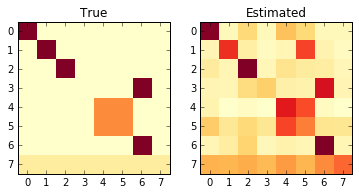

In [21]:
compare_conf_mats(conf_mats[:,:,1], weights[0][:,:,1])

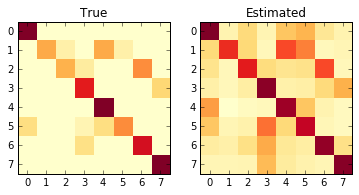

In [22]:
compare_conf_mats(conf_mats[:,:,2], weights[0][:,:,2])

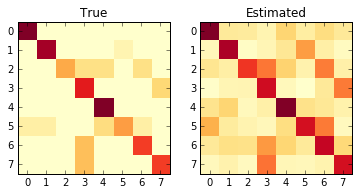

In [23]:
compare_conf_mats(conf_mats[:,:,9], weights[0][:,:,9])

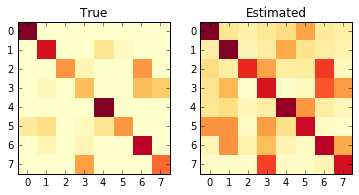

In [24]:
compare_conf_mats(conf_mats[:,:,20], weights[0][:,:,20])

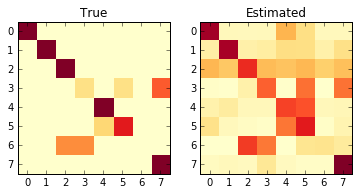

In [25]:
compare_conf_mats(conf_mats[:,:,23], weights[0][:,:,23])

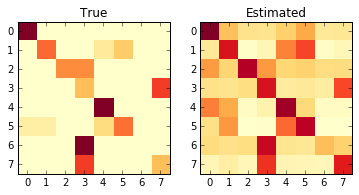

In [26]:
compare_conf_mats(conf_mats[:,:,30], weights[0][:,:,30])

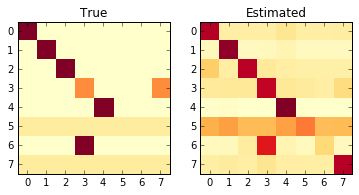

In [27]:
compare_conf_mats(conf_mats[:,:,36], weights[0][:,:,36])

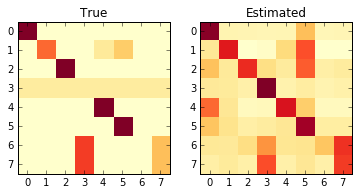

In [28]:
compare_conf_mats(conf_mats[:,:,39], weights[0][:,:,39])

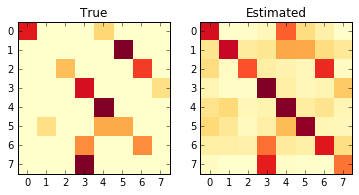

In [29]:
compare_conf_mats(conf_mats[:,:,45], weights[0][:,:,45])

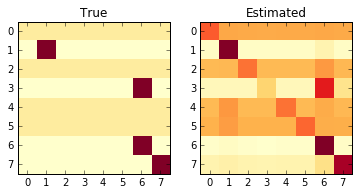

In [30]:
compare_conf_mats(conf_mats[:,:,56], weights[0][:,:,56])

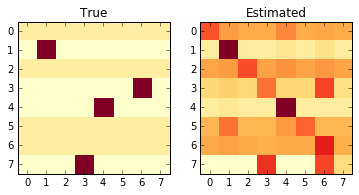

In [31]:
compare_conf_mats(conf_mats[:,:,58], weights[0][:,:,58])